<a href="https://colab.research.google.com/github/Preetjatania/skills-introduction-to-github/blob/main/Ass_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import least_squares                 # package to conduct Nonlinear least square

# import historical data
url = "https://raw.githubusercontent.com/zoutianxin1992/MarketingAnalyticsPython/main/Marketing%20Analytics%20in%20Python/2024/assignment%201/2024Q2-RobloxTotalUsers.csv"
df = pd.read_csv(url)
# Rename the variables to t and N_t
df.rename(columns = {df.columns[0]:"t",df.columns[1]:"N"}, inplace = True)  # "inplace" apply the name change to df itself
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   t       11 non-null     object
 1   N       11 non-null     int64 
 2   Users   11 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 396.0+ bytes


In [3]:
# define A_hat(t) and N_hat(t)

def A_hat(t,p,q,M):  #t: time, params: the 1*3 array for (p,q,M)
    return M * (1 - np.exp(-(p+q)*t))/(1 + q / p* np.exp(-(p+q)*t))

# define N_hat(t)
def N_hat(t,p,q,M):
    return A_hat(t,p,q,M) - A_hat(t-1,p,q,M)  # We can use the A_hat function to calculate N_hat instead of manually typing the formula

In [4]:
# define prediction errors as a fucntion of p,q,M
T = len(df["N"])   # number of periods for historical data


def prediction_error(params):   # Note that we input p,q,M as a 1*3 array "params." This is required by Python's NLS solver we will use.
    p = params[0]
    q = params[1]
    M = params[2]
    Nhat = [N_hat(t,p,q,M) for t in range(1,T+1)]            # Given p,q,M, generate Bass prediction for each period
    return df["N"] - Nhat                                 # The output is an array of prediction error for each period


In [5]:
# estimate p,q,M using least_squares
# Bass model requires 0<p<1, 0<q<1, M>0, so we need to add the constraints
A_t = sum(df['N'])           # calculate already adopters until period t
params0 = [0.01,0.16,3*A_t]  # initial guess for p,q,M. Required by least_squares
estim_results = least_squares(prediction_error, params0, bounds = (0,np.inf) )

#########################
# prediction_error: an array of prediction errors for each period
# param0: initial guesses
# bounds: The bounds for p,q,M. In our case p,q,M>0
#########################
estim_results
# Make sure "success" is True
# "x" is the estimated parameters (what we want).
# We don't worry about other parts for our purpose.

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-7.314e-01 -2.544e-01  9.086e-02  2.888e-01  3.345e-01
                2.415e-01  5.158e-02 -1.589e-01 -2.793e-01 -1.782e-01
                2.700e-01]
           x: [ 1.050e-02  2.815e-01  1.437e+02]
        cost: 0.5360892106673957
         jac: [[-1.638e+02 -8.969e-01 -1.205e-02]
               [-2.094e+02 -3.353e+00 -1.569e-02]
               ...
               [-3.364e+02 -4.861e+01 -7.084e-02]
               [-1.982e+02 -4.345e+01 -7.468e-02]]
        grad: [-5.039e-04  5.574e-05  3.609e-09]
  optimality: 0.0005038832650683389
 active_mask: [0 0 0]
        nfev: 8
        njev: 7

In [6]:
# store the estimation results
p_estim, q_estim, M_estim = estim_results.x
print(p_estim, q_estim, M_estim)

0.010503174448721243 0.2815416827836821 143.67913606994105


In [7]:
T_pred = 16  # number of periods for prediction
predictA = [A_hat(t,p_estim,q_estim,M_estim) for t in range(1,T_pred+1)]  # predict already adopters for T periods
predictN = [N_hat(t,p_estim,q_estim,M_estim) for t in range(1,T_pred+1)]  # predict new adopters for T periods

Text(0.5, 0, 'time')

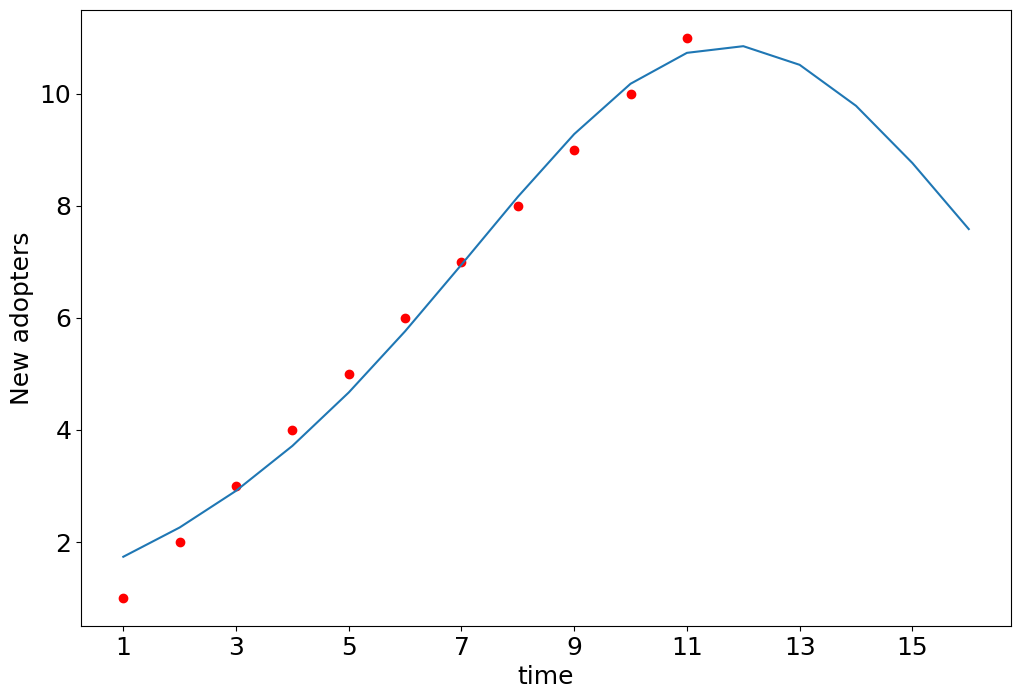

In [8]:
# Plot the trajectory of new adopters

plt.rcParams['figure.figsize'] = [12,8]  # set figure size to be 12*8 inch
plt.plot(range(1,T_pred+1),predictN)
plt.scatter(range(1,T+1),df["N"],color = "red")    # Also plot historical sales data
plt.xticks(range(1,T_pred+1,2), fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("New adopters",fontsize = 18)
plt.xlabel("time", fontsize = 18)